In [1]:
import cv2
import os

# Haar cascade for face detection
face_cascade = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")

# Folder to save images
folder_path = "Images for visualization"
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# List of people
people = ["Shalu", "Manish", "Ishwar"]
num_samples = 200  # Images per person

def capture_faces_for_person(person_name, num_samples=200):
    cap = cv2.VideoCapture(0)
    img_id = 0
    print(f"Capturing {num_samples} images for {person_name}...")
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.3, 5)

        for (x, y, w, h) in faces:
            img_id += 1
            face = gray[y:y+h, x:x+w]
            face = cv2.resize(face, (50,50))
            
            file_name = os.path.join(folder_path, f"{person_name}.{img_id}.jpg")
            cv2.imwrite(file_name, face)
            
            cv2.rectangle(frame, (x,y), (x+w, y+h), (0,255,0), 2)
            cv2.putText(frame, str(img_id), (x, y-10), cv2.FONT_HERSHEY_COMPLEX, 1, (0,255,0), 2)
        
        cv2.imshow(f"Capturing {person_name}", frame)
        if cv2.waitKey(1) == 13 or img_id >= num_samples:
            break

    cap.release()
    cv2.destroyAllWindows()
    print(f"Finished capturing {img_id} images for {person_name}.")

# Run capture for all people
for person in people:
    input(f"\nPress Enter when ready to capture images for {person}...")
    capture_faces_for_person(person, num_samples)



Press Enter when ready to capture images for Shalu... 


Capturing 200 images for Shalu...
Finished capturing 200 images for Shalu.



Press Enter when ready to capture images for Manish... yes


Capturing 200 images for Manish...
Finished capturing 200 images for Manish.



Press Enter when ready to capture images for Ishwar... 


Capturing 200 images for Ishwar...
Finished capturing 200 images for Ishwar.


In [3]:
import cv2
import numpy as np
import os
from random import shuffle

# Function to assign labels based on person
def get_label(image_name):
    name = image_name.split('.')[0]
    if name == "Shalu":
        return np.array([0])
    elif name == "Manish":
        return np.array([1])
    elif name == "Ishwar":
        return np.array([2])
    else:
        return np.array([3])  # For any extra person

# Load dataset
def load_data(folder_path="Images for visualization"):
    data = []
    for img in os.listdir(folder_path):
        path = os.path.join(folder_path, img)
        img_data = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img_data is None:
            continue
        img_data = cv2.resize(img_data, (50,50))
        label = get_label(img)
        data.append([img_data, label])
    shuffle(data)
    return data

data = load_data()
print("Total images loaded:", len(data))

# Split into train/test
total_images = len(data)
split_index = int(total_images * 0.8)
train = data[:split_index]
test = data[split_index:]

X_train = np.array([i[0] for i in train]).reshape(-1,50,50,1)
y_train = np.array([i[1] for i in train])

X_test = np.array([i[0] for i in test]).reshape(-1,50,50,1)
y_test = np.array([i[1] for i in test])

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


Total images loaded: 600
X_train shape: (480, 50, 50, 1)
X_test shape: (120, 50, 50, 1)
y_train shape: (480, 1)
y_test shape: (120, 1)


In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Input(shape=(50,50,1)),
    
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(people), activation='softmax')  # output = number of people
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 48, 48, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 22, 22, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 11, 11, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 9, 9, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 355,331 (1.36 MB)

 Trainable params: 355,331 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
history = model.fit(X_train, y_train,
                    epochs=15,
                    validation_data=(X_test, y_test),
                    batch_size=32)


Epoch 1/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 122ms/step - accuracy: 0.3667 - loss: 11.0082 - val_accuracy: 0.5250 - val_loss: 0.9581
Epoch 2/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.4774 - loss: 1.0763 - val_accuracy: 0.7583 - val_loss: 0.8446
Epoch 3/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.6105 - loss: 0.8820 - val_accuracy: 0.8417 - val_loss: 0.6793
Epoch 4/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.7625 - loss: 0.6536 - val_accuracy: 0.8750 - val_loss: 0.4513
Epoch 5/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.7791 - loss: 0.5636 - val_accuracy: 0.9083 - val_loss: 0.3782
Epoch 6/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.8372 - loss: 0.3980 - val_accuracy: 0.9083 - val_loss: 0.3218
Epoch 7/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.8805 - loss: 0.2909 - val_accuracy: 0.9500 - val_loss: 0.2564
Epoch 8/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.9239 - loss: 0.2619 - val_accuracy: 0.9500 -

In [9]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test Accuracy: {:.2f}%".format(test_acc*100))


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9881 - loss: 0.0392
Test Accuracy: 98.33%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


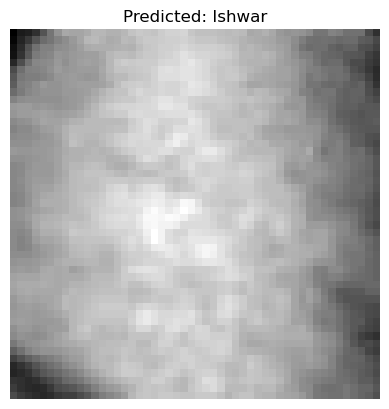

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


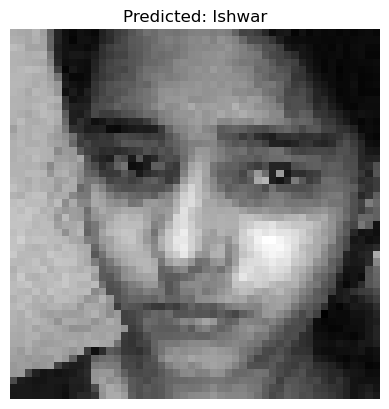

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


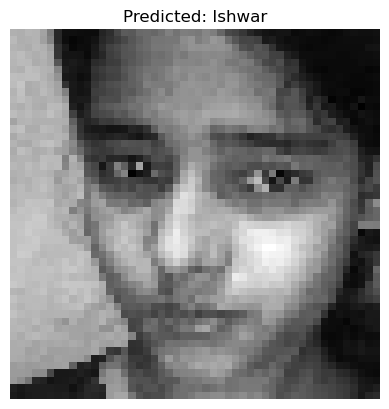

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


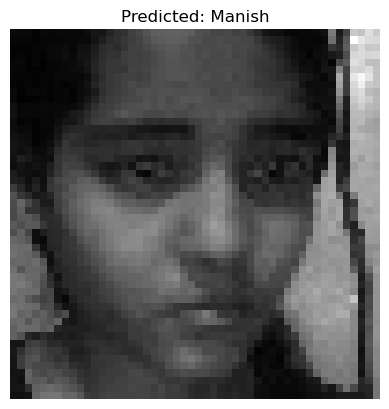

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


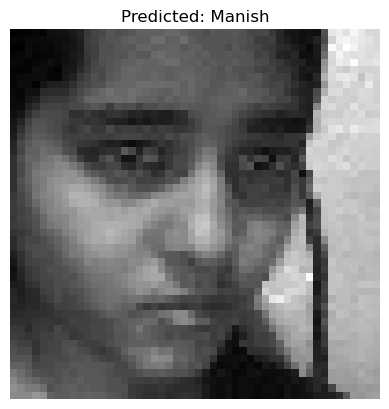

In [11]:
import matplotlib.pyplot as plt
import numpy as np

Vdata = test  # or you can create a separate folder for visualization

for img_data, img_label in Vdata[:5]:  # show first 5 images
    input_data = img_data.reshape(1,50,50,1)/255.0
    prediction = np.argmax(model.predict(input_data)[0])
    
    if prediction == 0:
        label = "Shalu"
    elif prediction == 1:
        label = "Manish"
    elif prediction == 2:
        label = "Ishwar"
    
    plt.imshow(img_data, cmap='gray')
    plt.title(f"Predicted: {label}")
    plt.axis('off')
    plt.show()
